# Composing transport plans across frames

In this notebook, I investigate the effects of composing transport plans to infer temporal couplings between MPs over long time intervals. Ultimately, the evidence suggests that this probably won't be accurate enough to use for OT-based regression on the Zimmer data if the time interval is longer than 10 frames.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from functools import reduce
from itertools import accumulate

import ot
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat 

from otimage import readers, viewers, imagerep
from otimage.utils import plot_maxproj

### Load data

In [3]:
# Load MP representations of video frames
mp_path = '/home/mn2822/Desktop/WormOT/data/zimmer/mp_components/mp_0000_0050.mat'
mp_data = loadmat(mp_path)

# Size of Zimmer images
img_shape = (890, 650, 33)

# TODO: Load this from file
n_frames = 50

cov = mp_data['cov']
pts = [mp_data['means'][t, :, :] for t in range(n_frames)]
wts = [mp_data['weights'][t, :, 0] for t in range(n_frames)]

### Compute transport plans for a set of frames

In [4]:
def compute_ot(pts_1, pts_2, wts_1, wts_2):
        
    # Normalize weights
    p_1 = wts_1 / np.sum(wts_1)
    p_2 = wts_2 / np.sum(wts_2)

    # Normalized distance matrix 
    M_nn = ot.dist(pts_1, pts_2, metric='sqeuclidean')
    M = M_nn / np.median(M_nn)

    # Compute transport plan
    P, _ = ot.emd(p_1, p_2, M, log=True)
    
    return P

In [5]:
t1 = 5
t2 = 45

p_mtx = []
q_mtx = []

for t in range(t1, t2):
    
    P = compute_ot(pts[t], pts[t + 1], wts[t], wts[t + 1])
    Q = P / np.sum(P, 1)[:, np.newaxis]
    
    p_mtx.append(P)
    q_mtx.append(Q)

### Visualize pushforward of composed transport plans

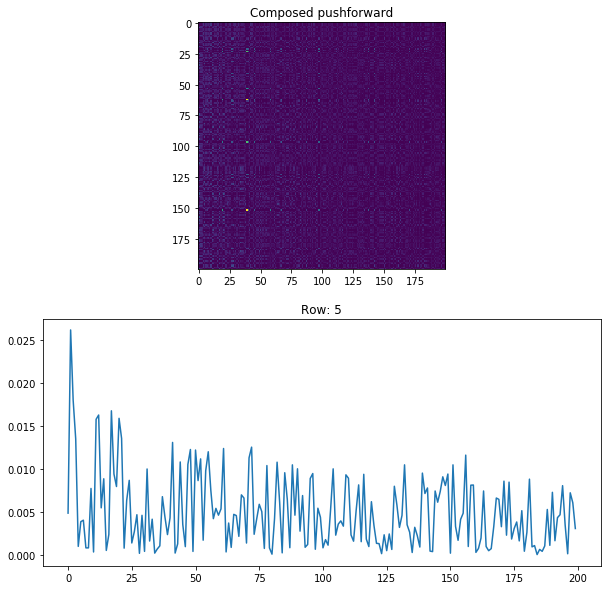

In [6]:
# Composed pushforward matrix
q_comp = q_mtx[0]
for q in q_mtx[1:]:
    q_comp = q_comp @ q
    
# Composed transport matrix
p_0 = np.sum(p_mtx[0], 1)[:, np.newaxis]
p_comp = p_0 * q_comp

plt.figure(figsize=(10, 10))

plt.subplot(211)
plt.imshow(q_comp)
plt.title('Composed pushforward')

row_plt = 5
plt.subplot(212)
plt.plot(q_comp[row_plt, :])
plt.title(f'Row: {row_plt}');

In [7]:
viewer = viewers.PushforwardViewer(
    pts[t1], pts[t2], wts[t1], wts[t2],
    cov, img_shape, q_comp
);

interactive(children=(IntSlider(value=0, continuous_update=False, description='MP:', max=200), Output()), _dom…

### Plot entropy of composed transport plans as a function of time interval length

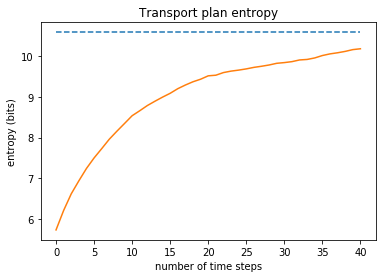

In [9]:
def mtx_entropy(P):
    vals = P[P > 0]
    return -np.sum(vals * np.log(vals)) 

# Compose transport matrices for all time steps
pc_mtx = accumulate([p_mtx[0]] + q_mtx, func=np.matmul)

# Compute entropy of each transport matrix
ent_vals = [mtx_entropy(p) for p in pc_mtx]

# Maximum possible entropy for transport matrix
n_states = p_mtx[0].shape[0] * p_mtx[0].shape[1]
ent_max = np.log(n_states)

# Number of time steps for each composition
t_steps = range(len(ent_vals))

plt.plot(t_steps, [ent_max] * len(t_steps), '--', label='maxent')
plt.plot(t_steps, ent_vals, label='H(P)')
plt.xlabel('number of time steps')
plt.ylabel('entropy (bits)')
plt.title('Transport plan entropy');